Этот ноутбук демонстрирует запуск модели Peleenet. Для того чтобы выполнить его:
1. скачайте оригинальный репозиторий
https://github.com/Robert-JunWang/PeleeNet.git
2. добавьте этот ноутбук в папку с оригинальным проектом 

In [4]:
import argparse
import json
import os 
import shutil 
import time 
import math 
import sys 

import numpy as np

import torch 
import torch.nn as nn 
import torch.nn.parallel 
import torch.backends.cudnn as cudnn 
import torch.distributed as dist 
import torch.optim 
import torch.utils.data 
import torch.utils.data.distributed 
import torchvision.transforms as transforms 
import torchvision.datasets as datasets
from sympy import resultant
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
from torchvision.io import read_image

from peleenet import PeleeNet
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch

import cv2

import torchvision.transforms as transforms
from PIL import Image

In [5]:
model_names = ['peleenet'] 
engine_names = ['torch']

In [6]:
parser = argparse.ArgumentParser(description='PeleeNet ImageNet Evaluation') 
parser.add_argument('data', metavar='DIR', help='data')
parser.add_argument('--arch', '-a', metavar='ARCH', default='peleenet',
                    choices=model_names,
                    help='model architecture: ' +
                        ' | '.join(model_names) +
                        ' (default: peleenet)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('-b', '--batch-size', default=2, type=int,
                    metavar='N', help='mini-batch size (default: 2)')
parser.add_argument('--print-freq', '-p', default=2, type=int,
                    metavar='N', help='print frequency (default: 2)')

parser.add_argument('--engine', '-e', metavar='ENGINE', default='torch', choices=engine_names,
                    help='engine type ' +
                        ' | '.join(engine_names) +
                        ' (default: torch)')
parser.add_argument('--weights', type=str, metavar='PATH', default='weights/peleenet_acc7208.pth.tar',
                    help='path to init checkpoint (default: none)')

parser.add_argument('--input-dim', default=224, type=int,
                    help='size of the input dimension (default: 224)')


_StoreAction(option_strings=['--input-dim'], dest='input_dim', nargs=None, const=None, default=224, type=<class 'int'>, choices=None, required=False, help='size of the input dimension (default: 224)', metavar=None)

In [7]:
best_prec1 = 0

In [8]:
global args, best_prec1
args = parser.parse_args(args=['data'])
args

Namespace(data='data', arch='peleenet', workers=4, batch_size=2, print_freq=2, engine='torch', weights='weights/peleenet_acc7208.pth.tar', input_dim=224)

In [9]:
def create_model(num_classes, engine='torch'):
    if engine == 'torch':
        if args.arch == 'peleenet':
                model = PeleeNet(num_classes=num_classes)
        else:
                print("=> unsupported model '{}'. creating PeleeNet by default.".format(args.arch))
                model = PeleeNet(num_classes=num_classes)

        model = torch.nn.DataParallel(model)#.cuda()

        if args.weights:
            if os.path.isfile(args.weights):
                print("=> loading checkpoint '{}'".format(args.weights))
                checkpoint = torch.load(args.weights, map_location=torch.device('cpu'))
                model.load_state_dict(checkpoint['state_dict'])
            else:
                print("=> no checkpoint found at '{}'".format(args.weights))

        cudnn.benchmark = True

    return model

In [10]:
print("=> creating {} model '{}'".format(args.engine, args.arch))
model = create_model(1000, args.engine)

=> creating torch model 'peleenet'
=> loading checkpoint 'weights/peleenet_acc7208.pth.tar'


C:\Users\Лиана\AppData\Local\Temp\ipykernel_21896\2989487456.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.weights, map_location=torch.de

In [11]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize(args.input_dim + 32),
    transforms.CenterCrop(args.input_dim),
    transforms.ToTensor(),
    normalize,
])

In [12]:
download_url("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json", ".", "imagenet_class_index.json")

Using downloaded and verified file: .\imagenet_class_index.json


In [13]:
with open("imagenet_class_index.json", "r") as h:
    labels = json.load(h)

In [14]:
image_dir = 'factory'
images_paths = []

In [15]:
for filename in os.listdir(image_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        filepath = os.path.join(image_dir, filename)
        images_paths.append(filepath)
images_paths

['factory\\test.png']

In [16]:
model.eval()

DataParallel(
  (module): PeleeNet(
    (features): Sequential(
      (stemblock): _StemBlock(
        (stem1): BasicConv2d(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (stem2a): BasicConv2d(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (stem2b): BasicConv2d(
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (stem3): BasicConv2d(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )


part 0


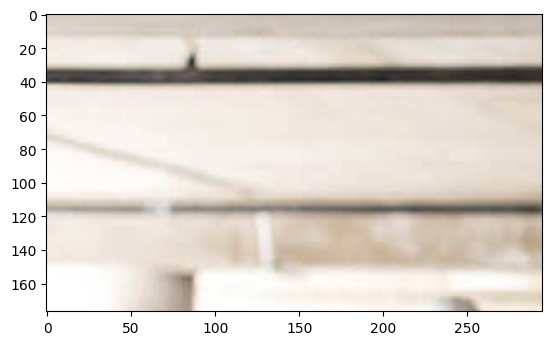

trombone (0.1582)
safety_pin (0.0751)
ladle (0.0664)
bow (0.0600)
parallel_bars (0.0347)
part 1


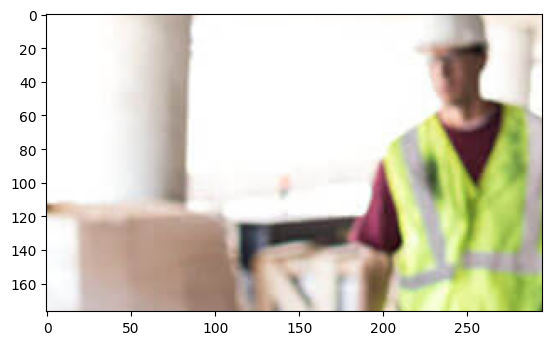

parallel_bars (0.0379)
neck_brace (0.0354)
horizontal_bar (0.0290)
bath_towel (0.0261)
swimming_trunks (0.0186)
part 2


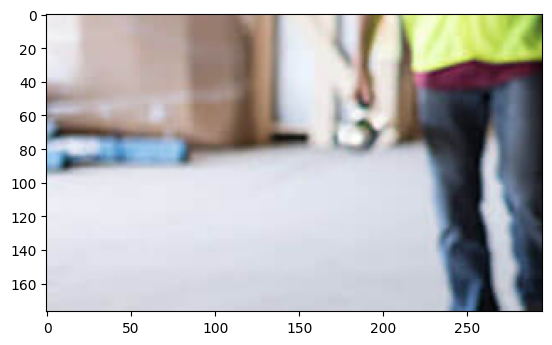

shoji (0.0536)
studio_couch (0.0328)
pool_table (0.0150)
tub (0.0113)
Cardigan (0.0110)
part 0


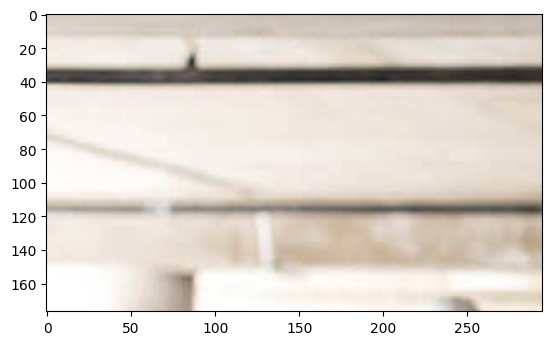

trombone (0.1582)
safety_pin (0.0751)
ladle (0.0664)
bow (0.0600)
parallel_bars (0.0347)
part 1


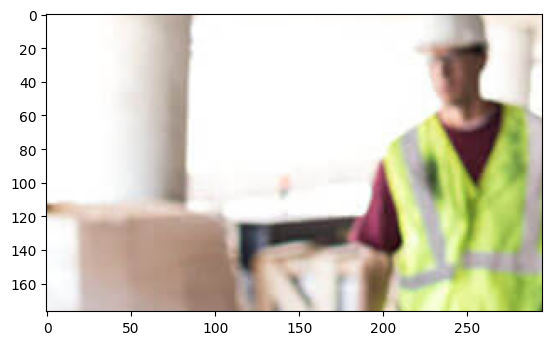

parallel_bars (0.0379)
neck_brace (0.0354)
horizontal_bar (0.0290)
bath_towel (0.0261)
swimming_trunks (0.0186)
part 2


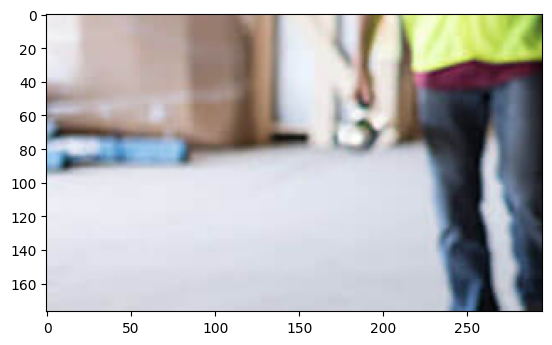

shoji (0.0536)
studio_couch (0.0328)
pool_table (0.0150)
tub (0.0113)
Cardigan (0.0110)
part 3


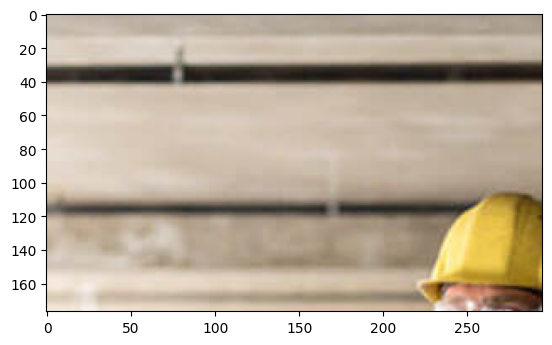

reel (0.1623)
parallel_bars (0.0824)
flute (0.0461)
drumstick (0.0355)
horizontal_bar (0.0335)
part 4


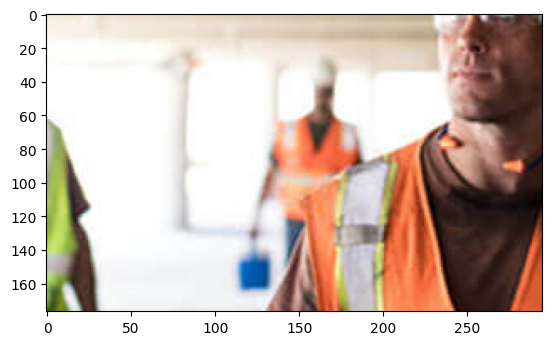

stretcher (0.3060)
kimono (0.1974)
academic_gown (0.0707)
parallel_bars (0.0482)
vestment (0.0453)
part 5


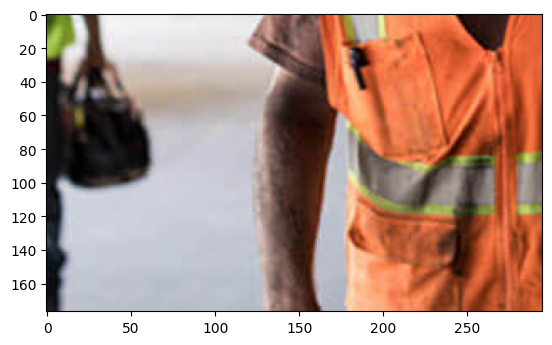

swimming_trunks (0.8166)
knee_pad (0.0633)
sarong (0.0165)
cowboy_boot (0.0053)
neck_brace (0.0041)
part 0


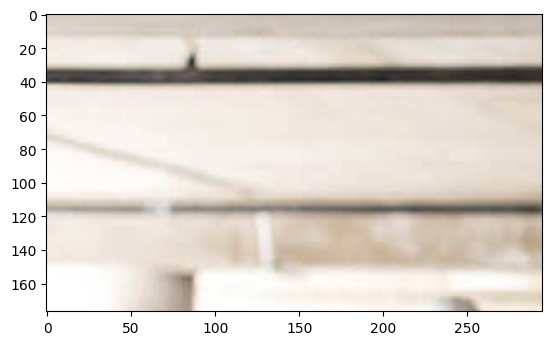

trombone (0.1582)
safety_pin (0.0751)
ladle (0.0664)
bow (0.0600)
parallel_bars (0.0347)
part 1


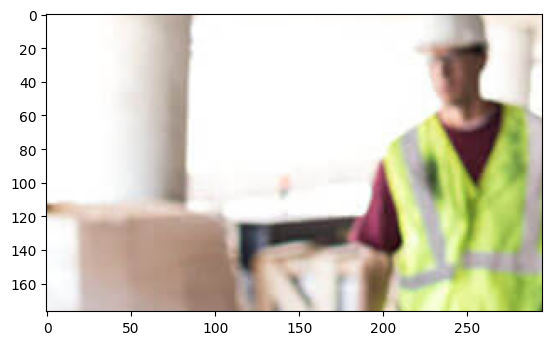

parallel_bars (0.0379)
neck_brace (0.0354)
horizontal_bar (0.0290)
bath_towel (0.0261)
swimming_trunks (0.0186)
part 2


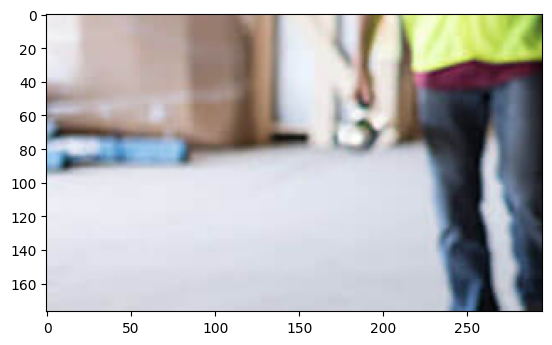

shoji (0.0536)
studio_couch (0.0328)
pool_table (0.0150)
tub (0.0113)
Cardigan (0.0110)
part 3


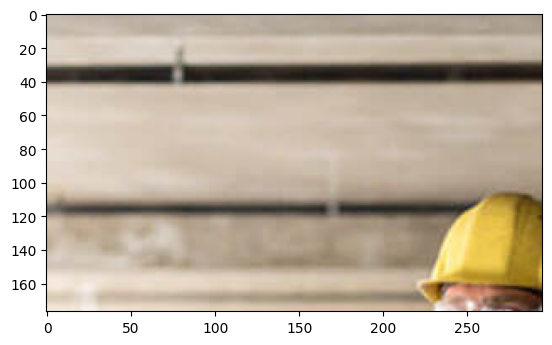

reel (0.1623)
parallel_bars (0.0824)
flute (0.0461)
drumstick (0.0355)
horizontal_bar (0.0335)
part 4


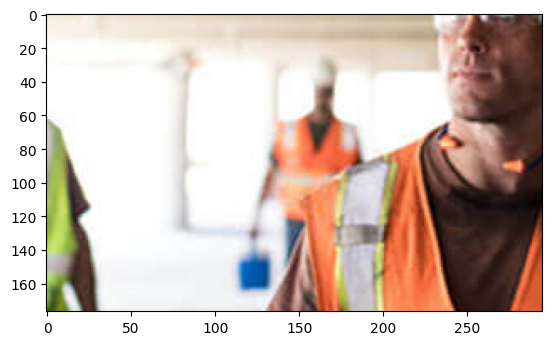

stretcher (0.3060)
kimono (0.1974)
academic_gown (0.0707)
parallel_bars (0.0482)
vestment (0.0453)
part 5


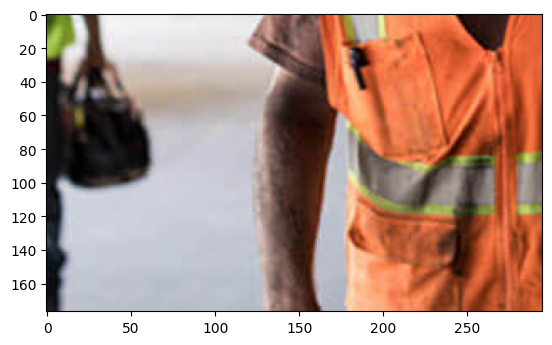

swimming_trunks (0.8166)
knee_pad (0.0633)
sarong (0.0165)
cowboy_boot (0.0053)
neck_brace (0.0041)
part 6


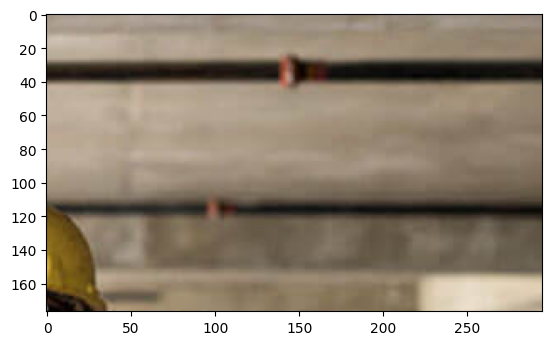

bow (0.2440)
bassoon (0.1063)
scabbard (0.0606)
hatchet (0.0408)
horizontal_bar (0.0329)
part 7


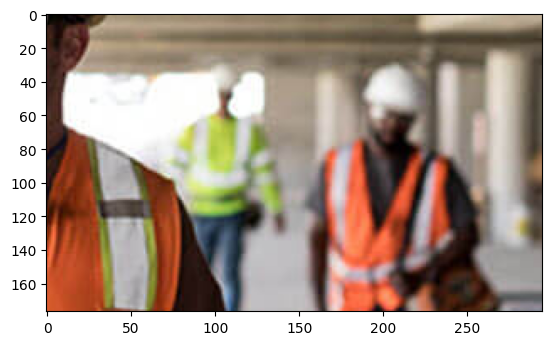

bearskin (0.0933)
academic_gown (0.0769)
prison (0.0538)
bow (0.0442)
abaya (0.0339)
part 8


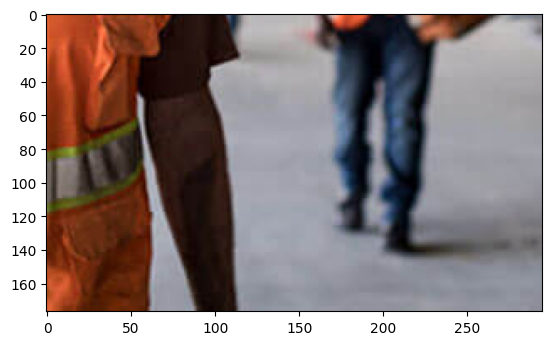

trench_coat (0.2079)
suit (0.1445)
sweatshirt (0.0459)
abaya (0.0420)
jersey (0.0377)


In [17]:
num_image = 0
for path in images_paths:
    img = Image.open(path).convert('RGB')
    width, height = img.size
    parts = []
    for i in range(3):
        for j in range(3):
            left = int(width * (i / 3))
            top = int(height * (j / 3))
            right = int(width * ((i + 1) / 3))
            bottom = int(height * ((j + 1) / 3))
            parts.append(img.crop((left, top, right, bottom)))

        for k, part in enumerate(parts):
            print(f'part {k}')
            img_t = transform(part)
            batch_t = torch.unsqueeze(img_t, 0)

            with torch.no_grad():
                out = model(batch_t)

            probabilities = torch.nn.functional.softmax(out, dim=1).squeeze()
            top5_probs, top5_indices = torch.topk(probabilities, 5)

            plt.figure()
            plt.imshow(part)
            plt.show()
            
            for i in range(5):
                print(f"{labels[str(top5_indices[i].item())][1]} ({top5_probs[i].item():.4f})")

        num_image += 1